# Reproducing the Experiment in "Prediction of Pedestrian Speed with Artificial Neural Networks" by Tordeux et al.

In [1]:
# Enable these if automatic reloading of modules is wanted

# Load extension for automatic reload of modules
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

import torch
from torch.utils.data import DataLoader
import logging
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import tensorboard
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import preprocessing
import plotting
import pedestrian_dataset
import pedestrian_net
from weidmann_method import *

## Tensorboard

Extension for visualizing the training results.
Should only be loaded once, otherwise there is probably an error message.

To start, run `tensorboard --logdir=dir --port 6006` in a terminal or run the following cell.

In [5]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6010

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
%reload_ext tensorboard

## Logging

I used Logging to print messages.
If more messages are welcome, use the logging level `logging.INFO` or even `logging.DEBUG`.
If not, use `logging.WARNING`.

In [7]:
# Set Logging Level
logger_format = '%(levelname)s - %(funcName)s \t%(message)s'
logger_level = logging.WARNING
logging.basicConfig(level=logger_level, format=logger_format)

In [8]:
# Set a torch seed
torch.manual_seed(1234)

## Preprocessing and Loading the Dataset

The different files of data in the format
(`PedID FrameID X Y Z`)
are loaded and converted into the following dictionary format:

`distances` | `speeds`
-|-
Input of our neural network. Array of size $2k+1$ containing the median speed of the $k$ nearest neighbors as the first element and the relative $x$- and $y$-positions of the $k$ nearest neighbors in the following pattern afterwards: $x_1$, $y_1$, $x_2$, $y_2$, ... | Truth value for our neural network. The speed that the pedestrian had in that frame.

To load a list of files, the method `pedestrian_dataset.create_dataset()` is used.
As its first parameter it either takes a list of data files that it should load
or a `pedestrian_dataset.PedestrianDataType` value,
which can be either `BOTTLENECK`, which loads all bottleneck files,
`CORRIDOR`, which loads all corridor files,
or `ALL`, which loads all files.

In [9]:
# Creating datasets with only the smallest corridor scenario with 30 participants
c_015_path = "./Data/Corridor_Data/ug-180-030.txt"
# Note: even when only loading one dataset, it has to be given in a list
c_015_train_val_datasets, c_015_test_dataset = pedestrian_dataset.create_dataset([c_015_path])

# Print the first item from the first train/val dataset part
print(c_015_train_val_datasets[0][0])

{'distances': array([ 296.80893951,   36.1585    ,  -91.69      ,   76.8931    ,
         62.0273    ,   -2.372     ,  201.1667    ,  -21.5438    ,
       -241.436     ,   29.8531    , -262.229     ,   32.8202    ,
        295.624     ,  -18.6053    ,  316.108     ,  -26.2509    ,
        437.719     ,   43.2941    ,  445.954     ,   -0.6295    ,
        559.384     ]), 'speed': 6.112364455756874}


In [10]:
batch_size = 16

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
c_015_temp_train_dataset = torch.utils.data.ConcatDataset(c_015_train_val_datasets[:4])
c_015_temp_val_dataset = c_015_train_val_datasets[4]

c_015_train_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=True)
c_015_val_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=False)

c_015_test_loader = DataLoader(c_015_test_dataset, batch_size=batch_size, drop_last=False)

# # Print the first value given by the train loader
# for item in c_015_train_loader:
#     print(item)
#     break  # break after printing the first item

In [11]:
# Creating datasets with all scenarios loaded
all_train_val_datasets, all_test_dataset = pedestrian_dataset.create_dataset(
    pedestrian_dataset.PedestrianDataType.ALL
)

# Print the first item from the first train/val dataset part
print(all_train_val_datasets[0][0])

{'distances': array([ 83.28914988, -32.428     ,  24.169     ,  37.9846    ,
        38.714     ,  -2.5528    , -57.585     ,   4.0326    ,
        69.008     ,  81.5544    ,   6.506     , -71.6767    ,
       -54.426     ,  49.6994    , -84.303     , -57.71222   ,
        80.09      ,  86.0264    , -55.428     ,  80.5664    ,
        75.733     ]), 'speed': 2.5783409394414765}


In [12]:
batch_size = 10000

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
all_temp_train_dataset = torch.utils.data.ConcatDataset(all_train_val_datasets[:4])
all_temp_val_dataset = all_train_val_datasets[4]

all_train_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=True)
all_val_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=False)

all_test_loader = DataLoader(all_test_dataset, batch_size=batch_size, drop_last=False)

# # Currently Disabled because for batch_size=16 this get's large
# # Print the first value given by the train loader
# for item in all_train_loader:
#     print(item)
#     break  # break after printing the first item

In [13]:
# Create normalized DataLoaders

normalized_train_loader = DataLoader(preprocessing.normalize_data(all_temp_train_dataset), batch_size=batch_size, drop_last=True)
normalized_val_loader = DataLoader(preprocessing.normalize_data(all_temp_val_dataset), batch_size=batch_size, drop_last=True)
normalized_test_loader = DataLoader(preprocessing.normalize_data(all_test_dataset), batch_size=batch_size, drop_last=False)

In [14]:
print(normalized_train_loader)

## Implementing and Training the Model

Now we need to define our model.

### Model 1 - Weidmann Method Fundamental Diagram

In [13]:
# Load the datasets with bottleneck and corridor data

bottleneck_train_val_dataset, bottleneck_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.BOTTLENECK)
corridor_train_val_dataset, corridor_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.CORRIDOR)
all_train_val_dataset, all_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.ALL)

KeyboardInterrupt: 

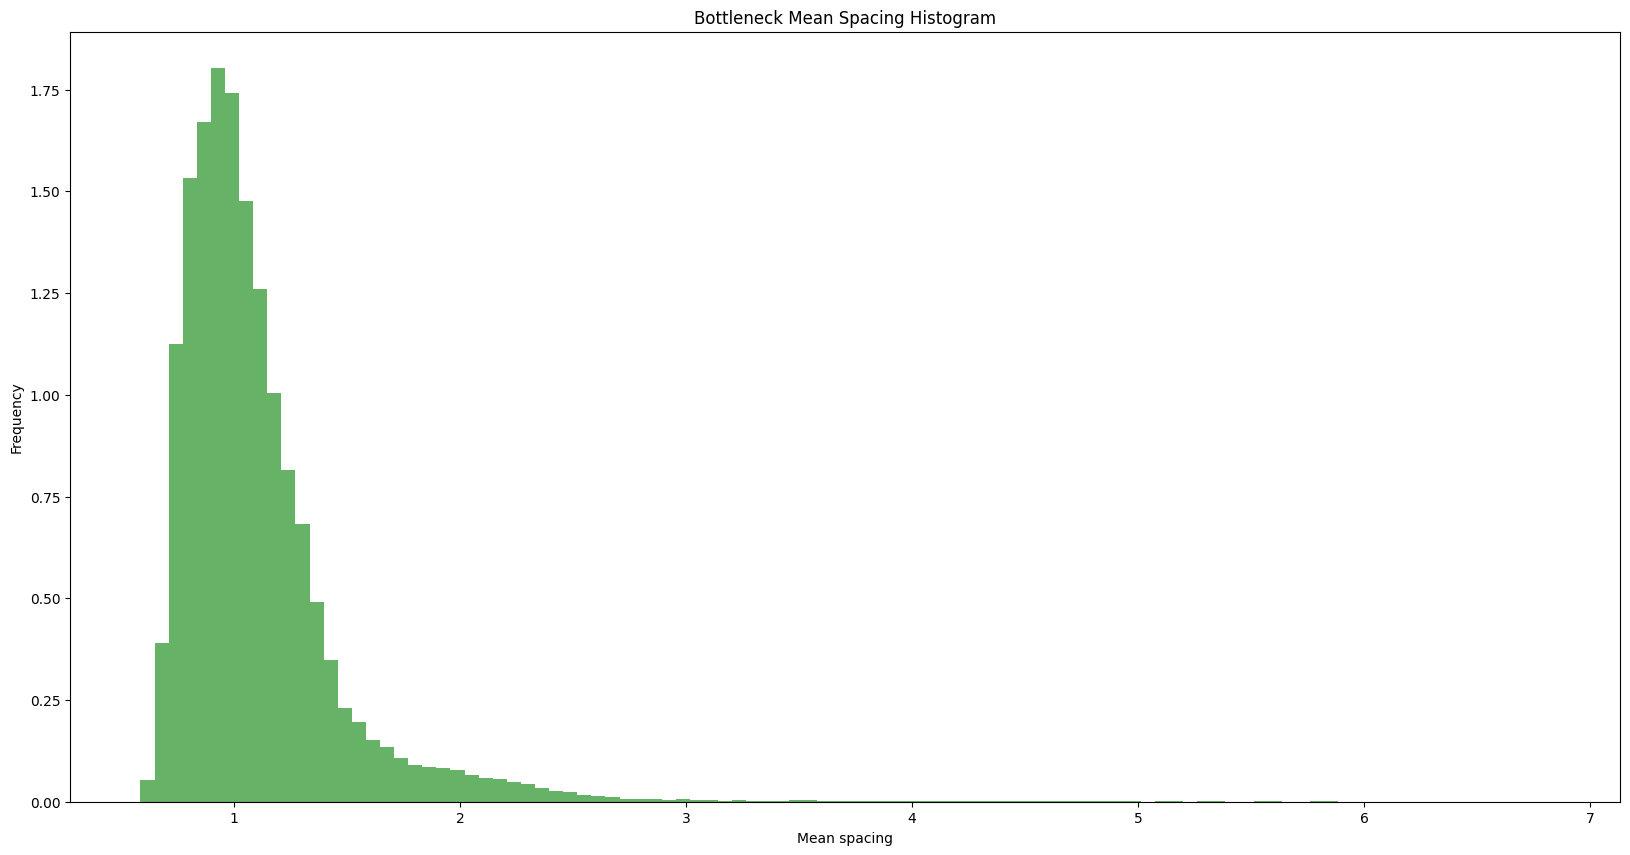

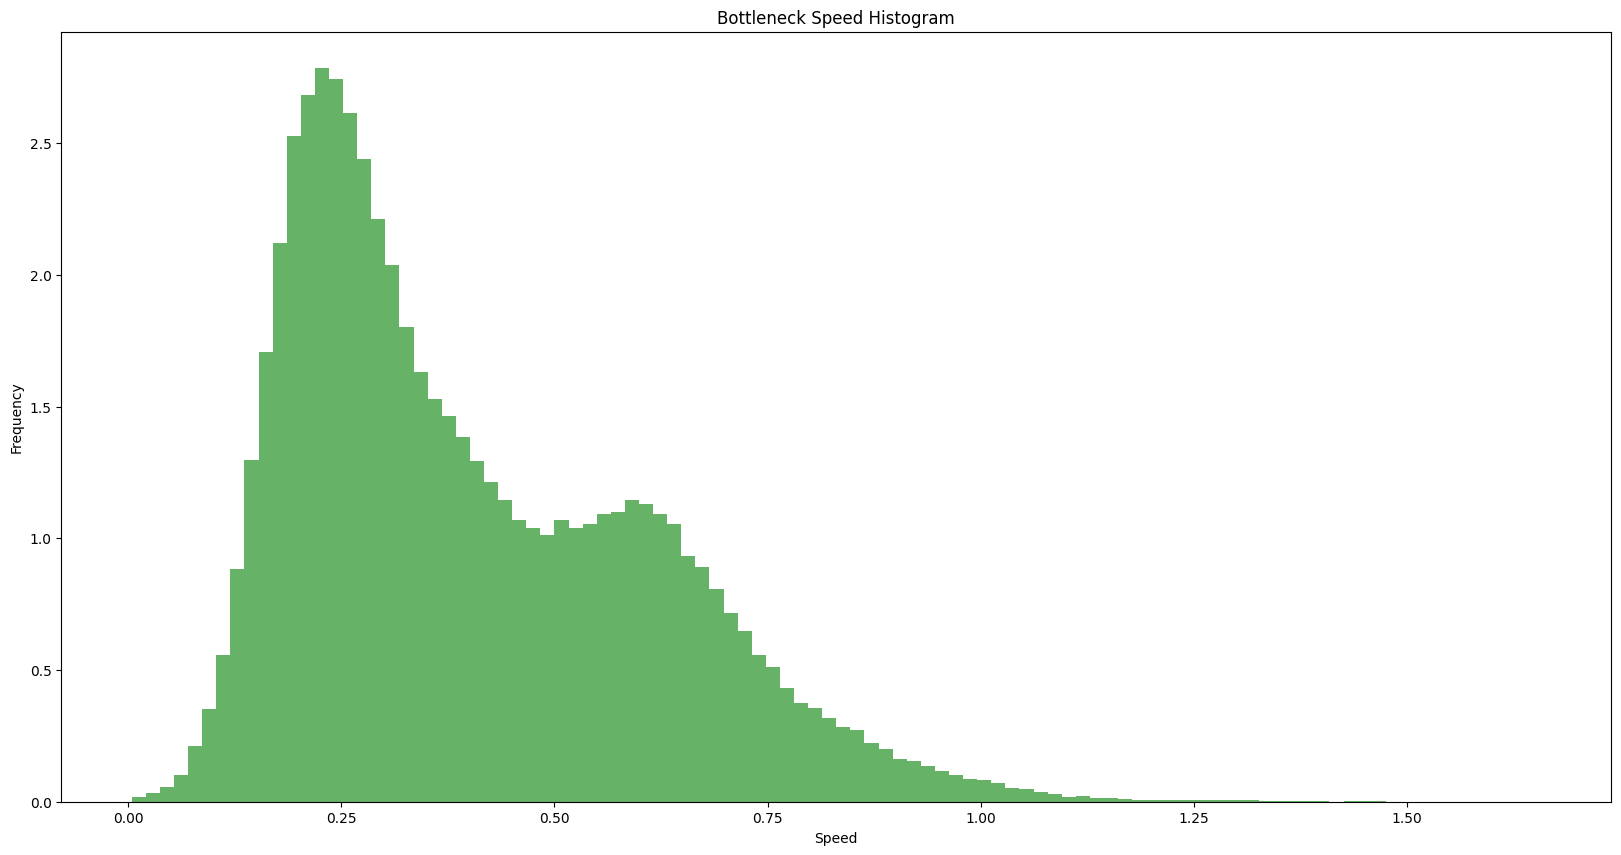

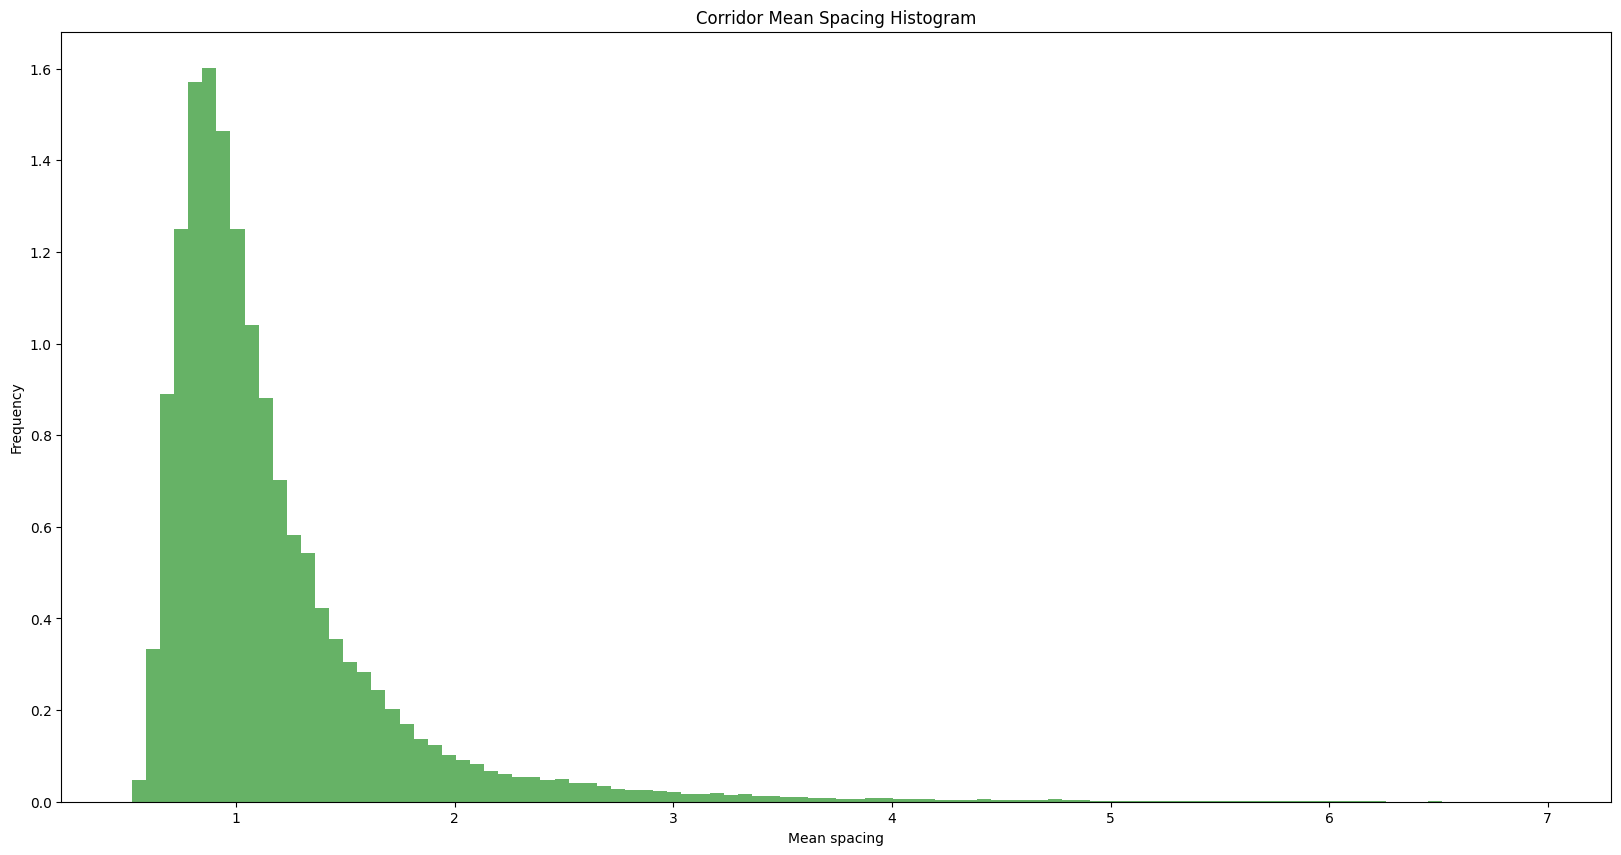

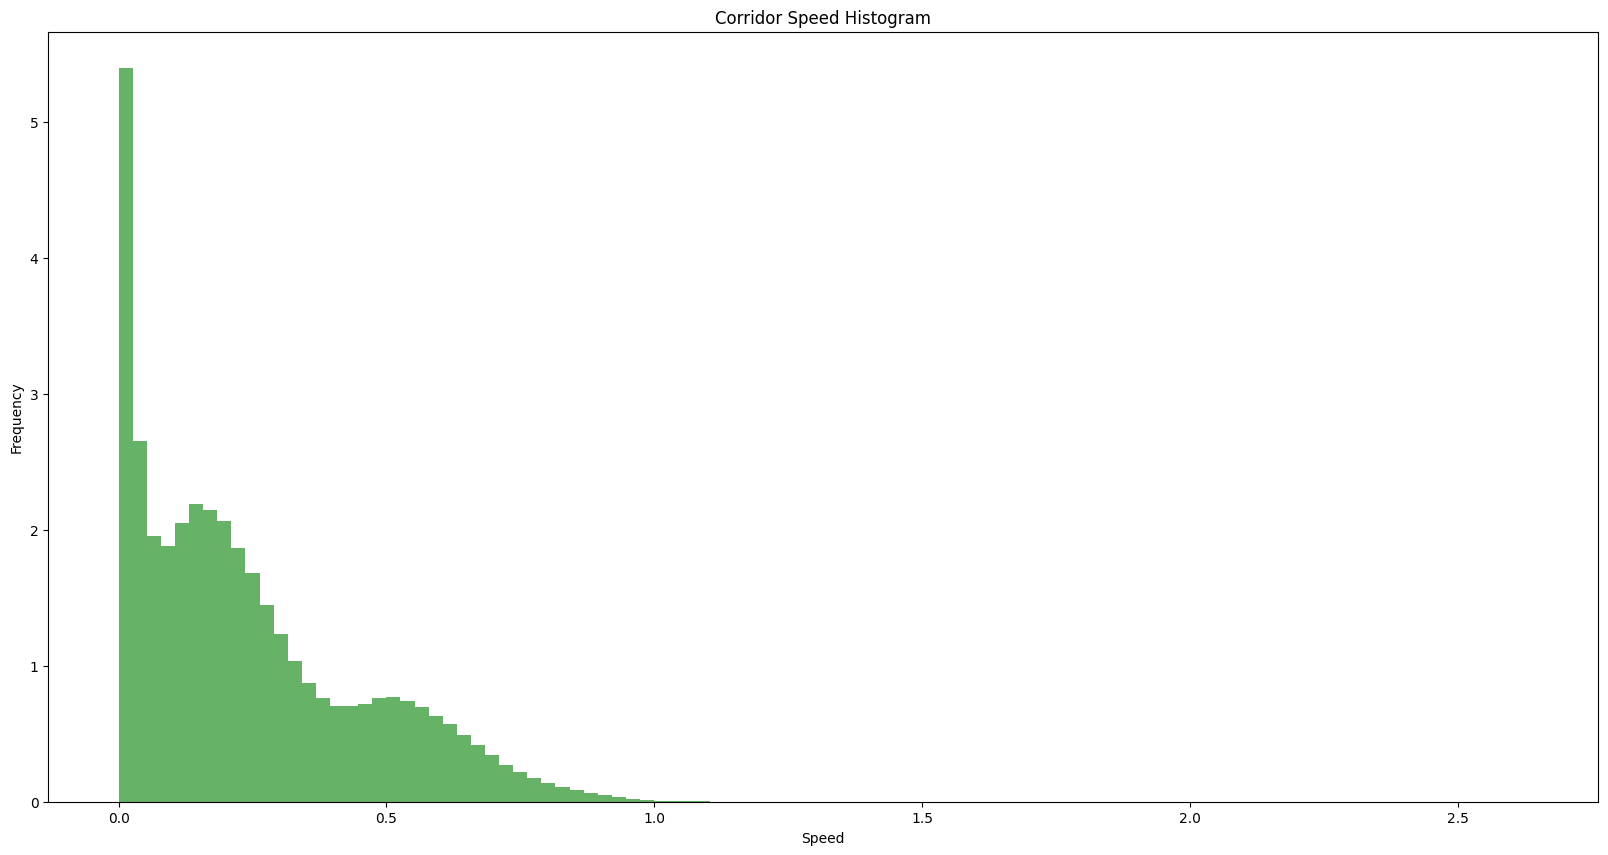

In [21]:
# See the histogram of bottleneck and corridor data for mean spacing and speed values
b_train_weidmann_x, b_train_weidmann_y, b_test_weidmann_x, b_test_weidmann_y = preprocessing.prepare_weidmann_data(bottleneck_train_val_dataset , bottleneck_test_dataset)
c_train_weidmann_x, c_train_weidmann_y, c_test_weidmann_x, c_test_weidmann_y = preprocessing.prepare_weidmann_data(corridor_train_val_dataset , corridor_test_dataset)

# Concatenate the train and test data to get the full dataset in order to plot the histogram
b_dataset_mean_spacing = b_train_weidmann_x + b_test_weidmann_x
b_dataset_speed = b_train_weidmann_y + b_test_weidmann_y
c_dataset_mean_spacing = c_train_weidmann_x + c_test_weidmann_x
c_dataset_speed = c_train_weidmann_y + c_test_weidmann_y

# Plot the histograms
plotting.plot_histogram(b_dataset_mean_spacing, xlabel='Mean spacing',  title='Bottleneck Mean Spacing Histogram')
plotting.plot_histogram(b_dataset_speed, xlabel='Speed',  title='Bottleneck Speed Histogram')

plotting.plot_histogram(c_dataset_mean_spacing, xlabel='Mean spacing',  title='Corridor Mean Spacing Histogram')
plotting.plot_histogram(c_dataset_speed, xlabel='Speed',  title='Corridor Speed Histogram')

Optimized parameters:  [0.99459926 0.52054795 1.02308064]


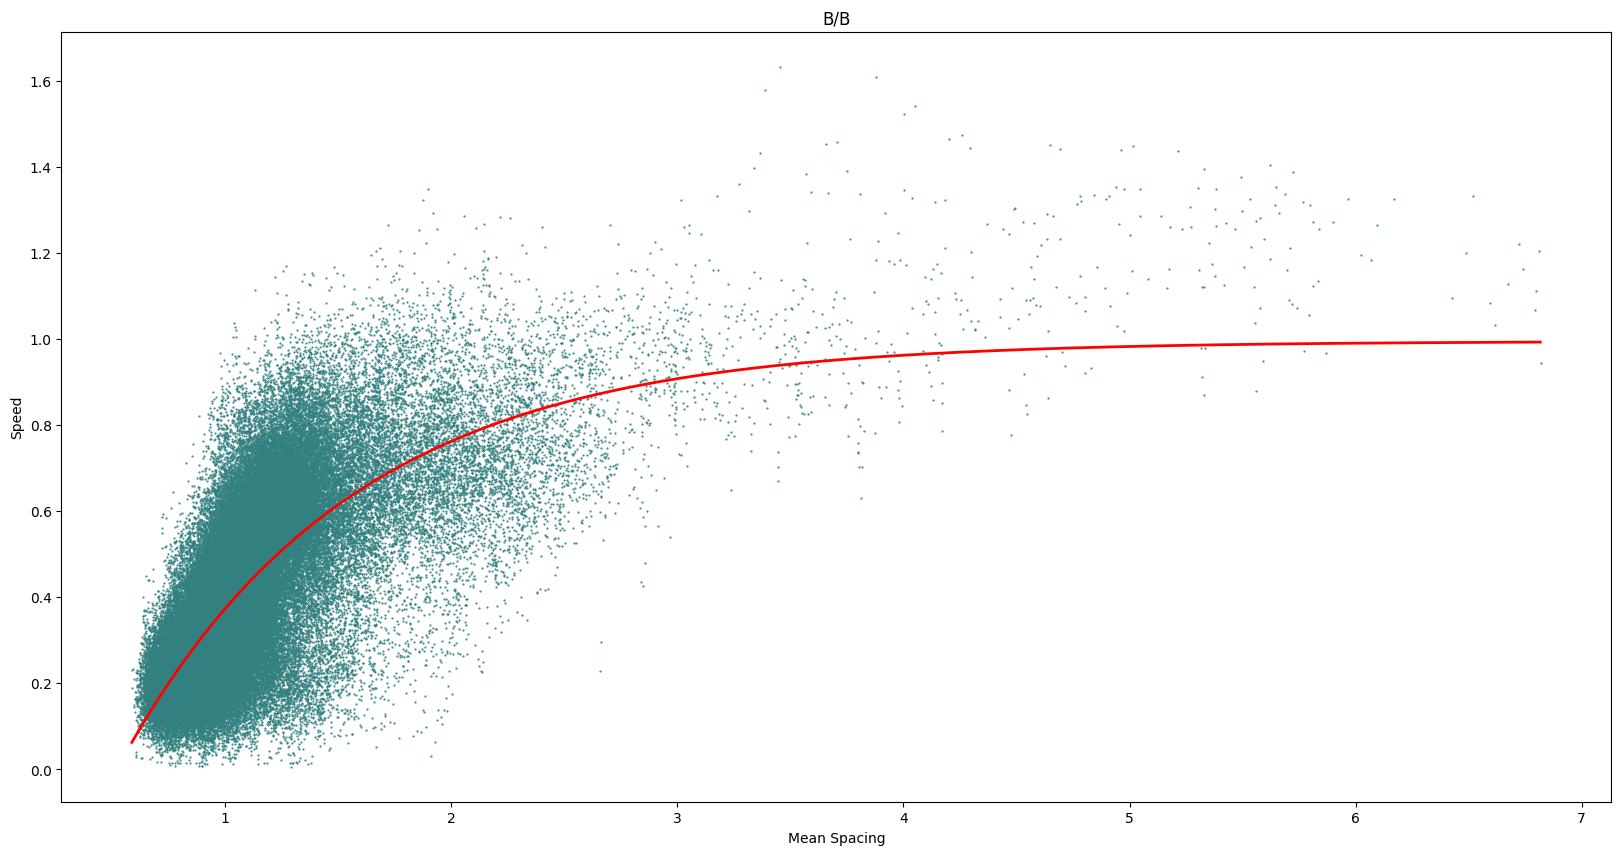

Optimized parameters:  [0.75831408 0.62022338 1.51903569]


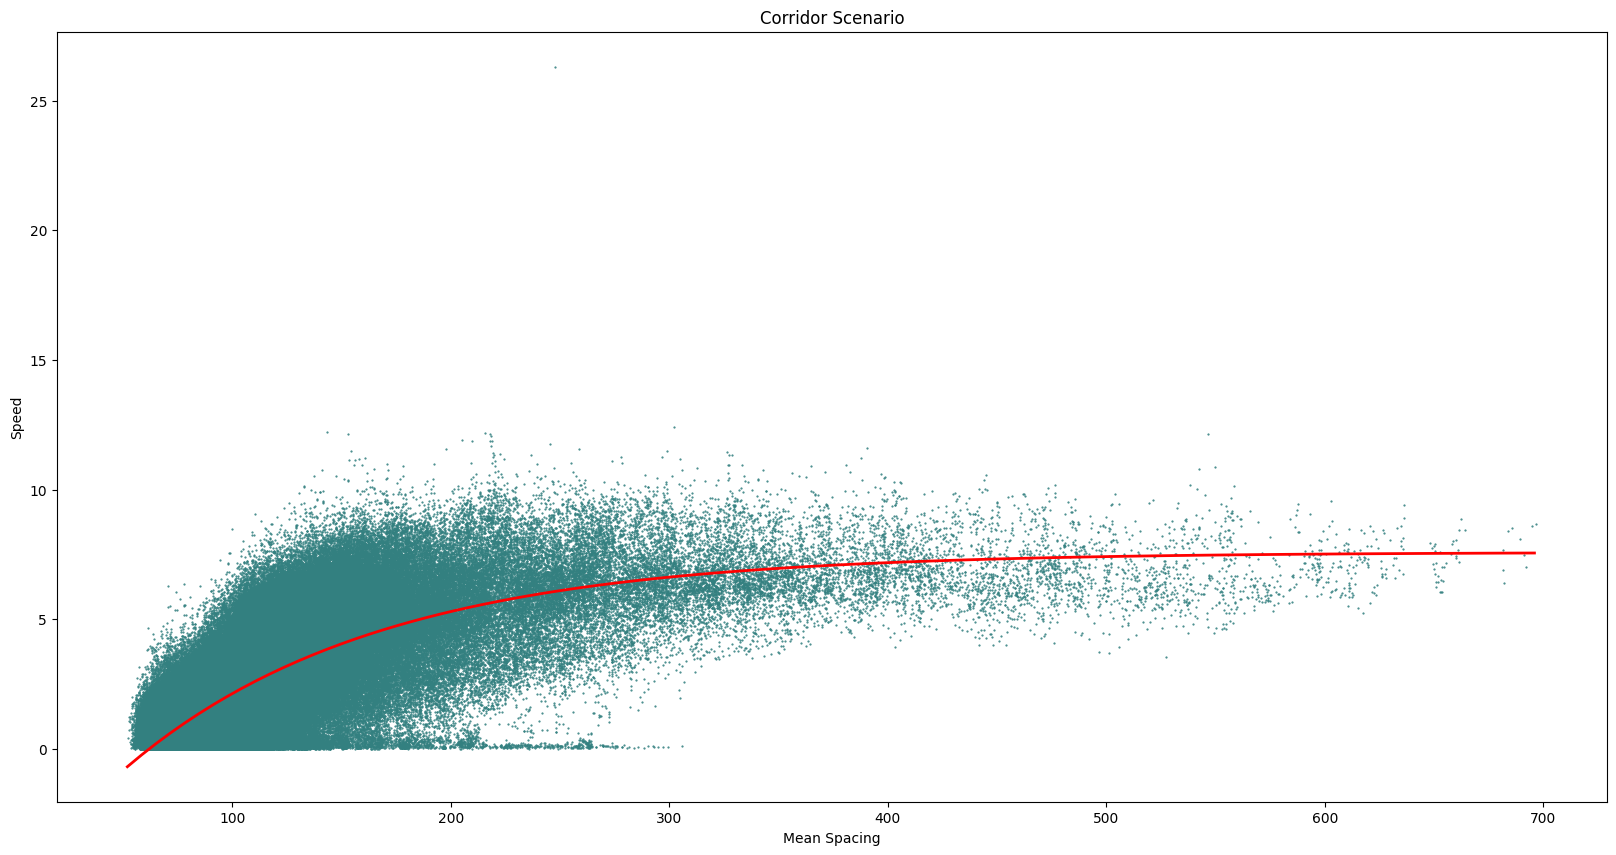

Optimized parameters:  [0.75831408 0.62022338 1.51903569]


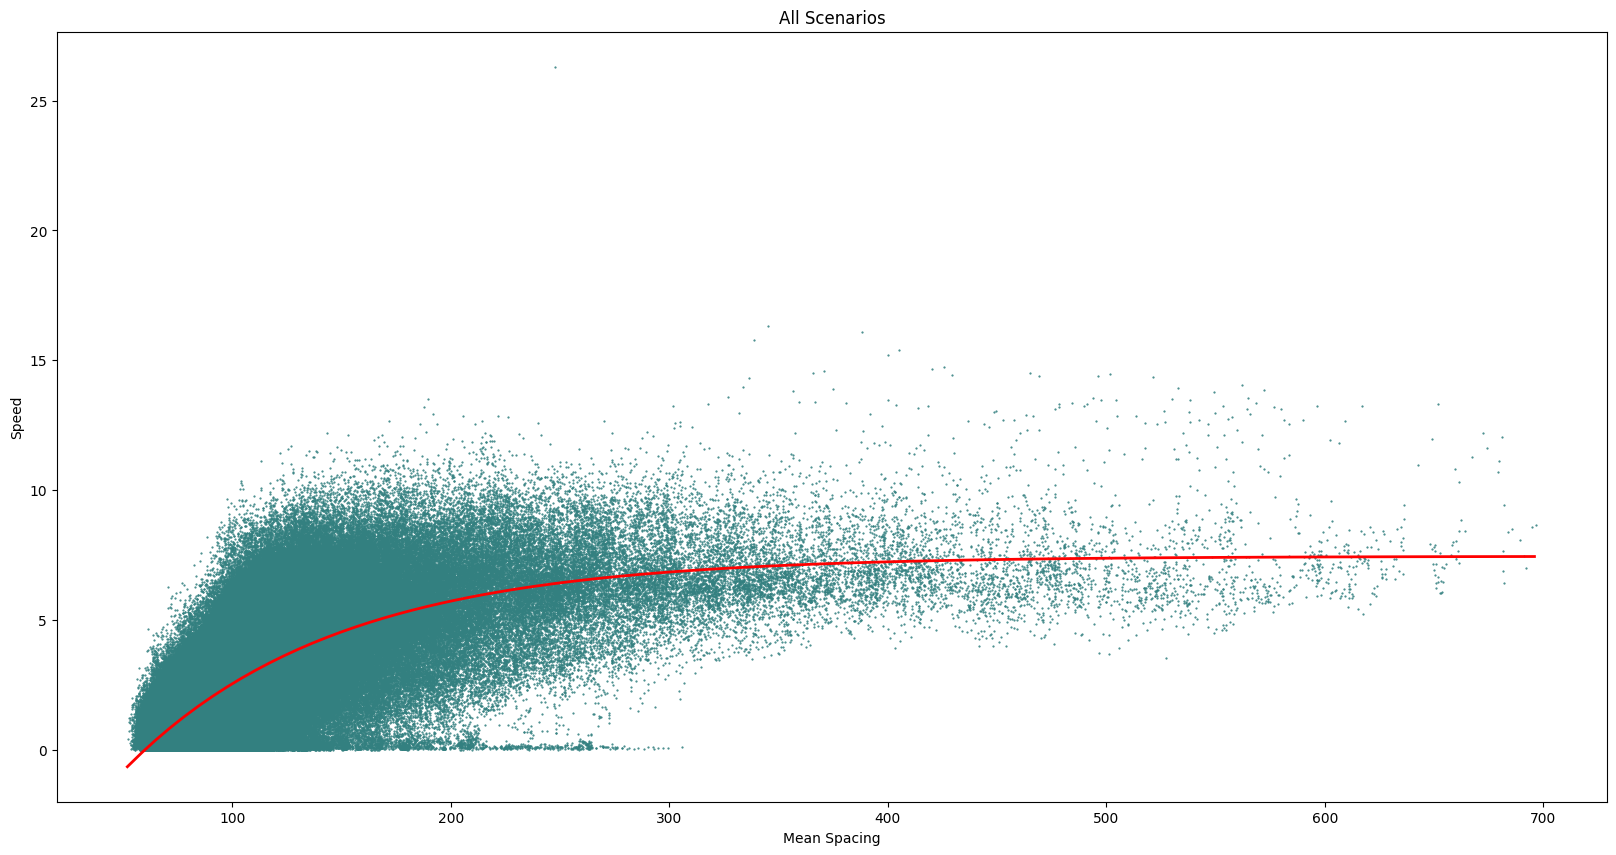

In [13]:
# Adjust the experiment datasets wıth different combinations of bottleneck and corridor data
load_dataset = {'B/B': [bottleneck_train_val_dataset, bottleneck_test_dataset],
                'R/R': [corridor_train_val_dataset, corridor_test_dataset ], 
                'B/R': [bottleneck_train_val_dataset, corridor_test_dataset],
                'R/B': [corridor_train_val_dataset, bottleneck_test_dataset],
                'R+B/R': [all_train_val_dataset, corridor_test_dataset], 
                'R+B/B': [all_train_val_dataset, bottleneck_test_dataset],
                'R+B/R+B': [all_train_val_dataset, all_test_dataset]}

# Set the initial guess for the Weidmann method
initial_guess = [1, 1, 1]

mse_dic = {}
for i in load_dataset:
    # Prepare the data for the Weidmann method
    train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y = preprocessing.prepare_weidmann_data(load_dataset[i][0], load_dataset[i][1])

    # Use the Weidmann method to fit the data and get the optimized parameters and the mean squared error (mse)
    optimized_parameters, mse, y_fit = use_weidmann_method(train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y, initial_guess=initial_guess)
    #print("Optimized parameters: ", optimized_parameters)
    # Plot the results for test data 
    curve_model = np.arange(min(test_weidmann_x), max(test_weidmann_x), 0.01)
    curve_pred = weidmann_equation(curve_model, *optimized_parameters)
    plot_fd_curve(test_weidmann_x, test_weidmann_y, curve_model, curve_pred, title=i)
    mse_dic[i] = mse

{'B/B': 0.02005468739833246, 'R/R': 0.019752375643579286, 'B/R': 0.04880653652427651, 'R/B': 0.048283510767569156, 'R+B/R': 0.02136058870671394, 'R+B/B': 0.03634302896394584, 'R+B/R+B': 0.02488066500926068}


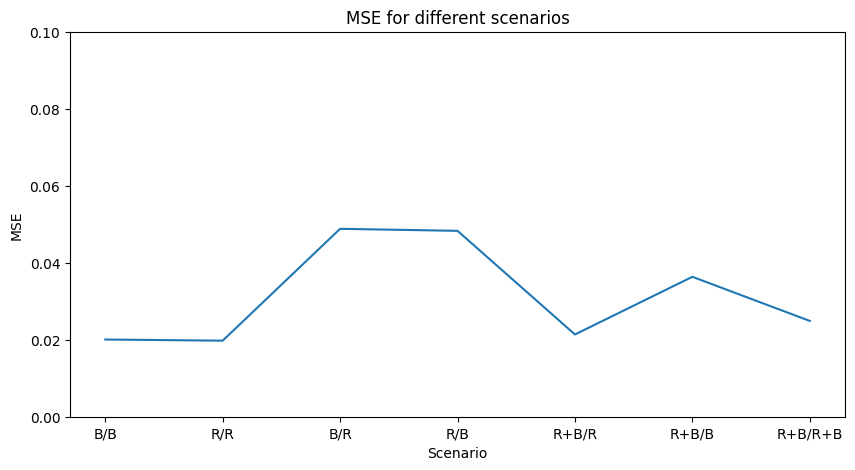

In [16]:
# Plot MSE results as a line plot
plt.figure(figsize=(10, 5))
plt.ylim(ymin=0, ymax=0.1)
plt.plot(list(mse_dic.keys()), list(mse_dic.values()))
plt.title('MSE for different scenarios')
plt.xlabel('Scenario')
plt.ylabel('MSE')
plt.show()

### Model 2 - Artificial Neural Networks

### Set up hyper parameters

In [65]:
max_epochs = 20
k = 10
hidden_size = 3
learning_rate = 1e-2
optimizer = torch.optim.Adam

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("CPU will be used.")

# define an early stopping callback
early_stop_callback = EarlyStopping(monitor="val_loss", mode='min', patience=1000)

GPU is available.


#### Combine all datasets to prepare for K-fold training

In [ ]:
# combine all your data into one dataset
dataset = preprocessing.normalize_data(torch.utils.data.ConcatDataset(all_train_val_datasets))

#### Set up all models with different layers

In [ ]:
all_models = [[1], [2], [3], [4,2], [5,2], [5,3], [6,3], [10,4]]

#### Initialize the KFold class

In [1]:
k_folds = 50
kfold = KFold(n_splits=k_folds, shuffle=True)

NameError: name 'KFold' is not defined

### Train for all models and all KFolds and save mean values for each model

In [ ]:
mean_train_losses = []
mean_test_losses = []

for layer_sizes in all_models:
    train_losses = []
    test_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):  
        print(f"FOLD {fold}")
        print("--------------------------------")

        # Sample elements randomly from a given list of ids, with replacement.
        train_subsampler = torch.utils.data.sampler.WeightedRandomSampler(torch.ones_like(torch.from_numpy(train_ids)), len(train_ids), replacement=True)

        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=10000, sampler=train_subsampler)  
        valloader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=10000, sampler=val_subsampler)

        # Init the neural network
        network = pedestrian_net.PedestrianNet(k=k,
                                               hidden_sizes=layer_sizes,
                                               learning_rate=learning_rate,
                                               optimizer=optimizer)
        network.to(device)

        # Initialize a trainer
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            devices='auto',
            accelerator='gpu',
            callbacks=[early_stop_callback],
            log_every_n_steps=1,
            enable_checkpointing=True
        )

        # Train the network
        trainer.fit(network, trainloader, valloader)

        # Save the current model (checkpoint)
        checkpoint_name = f"./.name/checkpoints/2023-07-05--dataAll-ep100-it001-fold{fold}.ckpt"
        trainer.save_checkpoint(checkpoint_name)
        
        # Save train losses
        train_losses.append(trainer.callback_metrics["train_loss"].numpy())
        
        # Test model
        result = trainer.test(network, dataloaders=normalized_test_loader)
        
        # Save test losses
        test_losses.append(result[0]["TEST_LOSS"])
        
    print("Training finished for model: ", network)
        
    mean_train_losses.append(np.mean(train_losses))
    mean_test_losses.append(np.mean(test_losses))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


FOLD 0
--------------------------------
Sanity Checking: 0it [00:00, ?it/s]

C:\Users\sukap\anaconda3\envs\i2dl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


In [57]:
mean_train_losses

[0.0551457796119925,
 0.049760667285213625,
 0.047195622203477464,
 0.07285599322227161,
 0.06175138400120028,
 0.03982148111294393,
 0.021588159663545343,
 0.029813085264152373]

In [58]:
mean_test_losses

[0.022641932983087094,
 0.015148694454500471,
 0.013732831912461742,
 0.016554333701058733,
 0.015702050793835052,
 0.011362147508880656,
 0.011032816574647237,
 0.01106928198332146]

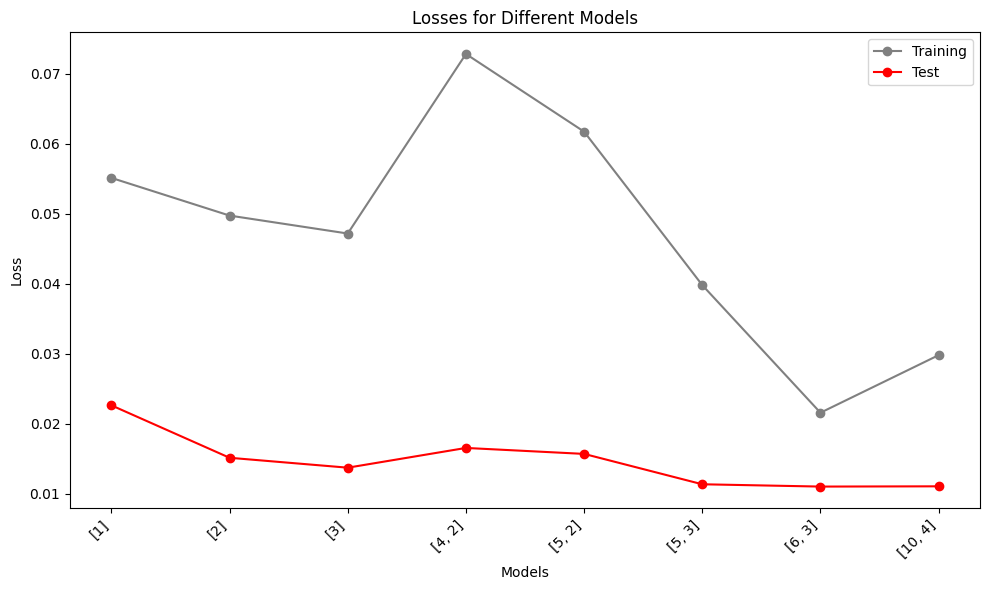

In [63]:
plot_losses(mean_train_losses, mean_test_losses, all_models)
